In [ ]:
# Cell for setting parameters
# This program generates the quantum state
# \sum_{i \in S} \ket{i}_n
n = 8
S = [1, 5, 25, 97, 77, 88, 33, 27, 19, 240, 255, 59, 30]

In [ ]:
# Cell for installing the necessary Qiskit libraries
!pip install qiskit ipywidgets  # Install Qiskit and ipywidgets
!pip install --upgrade qiskit   # Upgrade Qiskit to the latest version
!pip install qiskit-aer         # Install Qiskit Aer for high-performance simulators
!pip install pylatexenc         # Install pylatexenc for LaTeX support

In [ ]:
# Cell for functions
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram
import math
import random

# Normalize the input vector 'a' so that the sum of the squares of its elements equals 1.
def normalize_vector(a):
    sq_sum = 0
    for e in a:
        sq_sum += e*e
    sqrt_sq_sum = math.sqrt(sq_sum)
    for i in range(len(a)):
        a[i] = a[i] / sqrt_sq_sum

# Convert a Binary code x to its corresponding Gray code.
def bin_to_gray(x):
    return x^(x>>1)

# Build the alpha matrix
# alpha here includes \alpha^1, \alpha^2, ...
# page 7, Line 245
def build_alpha(a, n):
    alpha = [ [] for _ in range(n+1)]

    for k in range(1,n+1):
        r = 1<<(n-k)
        alpha[k].append(0)
        for j in range(1,r+1):
            x = y = 0
            for l in range(1, (1<<(k-1))+1):
                x += a[(2*j-1)*(1<<(k-1))+l] * a[(2*j-1)*(1<<(k-1))+l]
            for l in range(1, (1<<(k))+1):
                y += a[(j-1)*(1<<k)+l] * a[(j-1)*(1<<k)+l]
            if y == 0:
                alpha[k].append(0)
            else:
                alpha[k].append(2*math.asin(math.sqrt(x/y)))

    return alpha

# Convert alpha to theta
# page 8, Line 259
def alpha_to_theta(alpha, n):
    theta = [ 0 for _ in range((1<<n)+1)]
    x = 1/(1<<n)
    M = [ [ x for _ in range((1<<n)+1)] for __ in range((1<<n)+1)]

    for i in range(1,(1<<n)+1):
        for j in range(1,(1<<n)+1):
            b = j-1
            g = bin_to_gray(i-1)
            p = 0
            for k in range(8):
                p ^= ((b>>k)&1)&((g>>k)&1)
            if p == 1:
                M[i][j] = -M[i][j]

    for i in range(1,(1<<n)+1):
        for j in range(1,(1<<n)+1):
            theta[i] += M[i][j]*alpha[j]

    return theta

# Find the positions for controlled qubit for CNOT gate
# $q$ in the manuscript L
# page 8, Line 260
def cx_find(n):
    if n == 1:
        return []
    if n == 2:
        return [1,1]
    a = cx_find(n-1)
    a[-1] = a[-1]+1
    return a+a

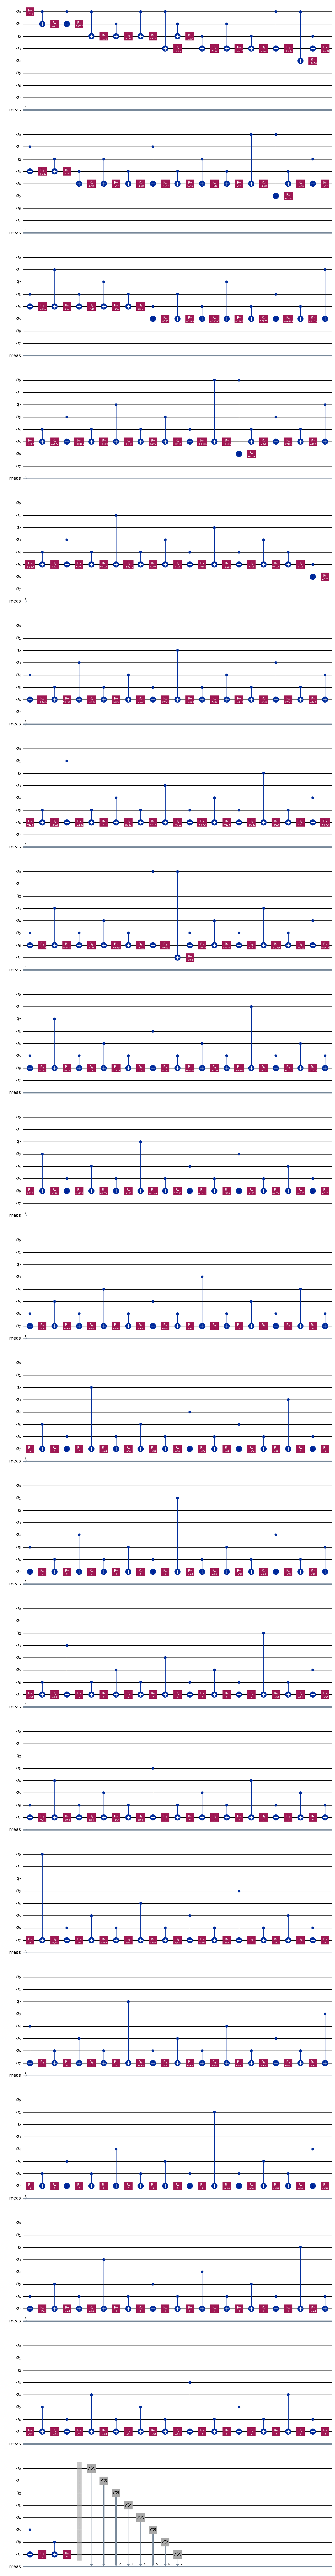

In [ ]:
# Cell for constructing quantum gate
a = [0]*((1<<n)+1)
for i in S:
    j = format(i, f'0{n}b')
    j = j[::-1]
    j = int(j, 2)
    j += 1
    a[j] = 1
normalize_vector(a)
alpha = build_alpha(a,n)
theta = []
theta.append([])
for i in range(1,n+1):
    theta.append(alpha_to_theta(alpha[i], n-i))

qc = QuantumCircuit(n)
for i in range(n):
    cx = cx_find(i+1)
    for j in range(1<<i):
        if i != 0:
            qc.cx(i-cx[(1<<i)-1-j],i)
        qc.ry(-theta[n-i][j+1],i)

qc.measure_all()

qc.draw(output='mpl')

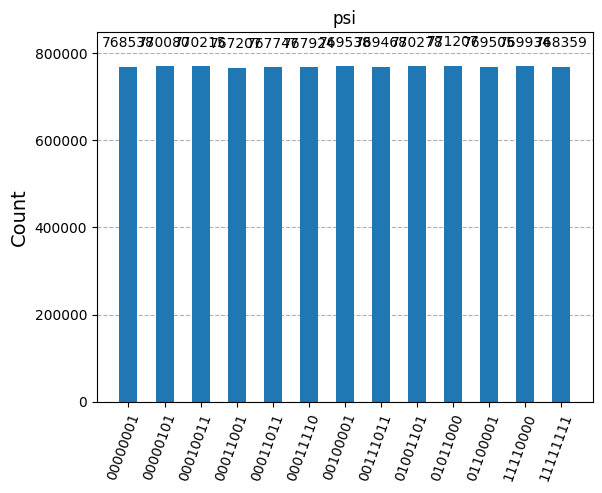

In [ ]:
# Cell to validate the generation of the desired quantum state
simulator = Aer.get_backend('aer_simulator')
qc = transpile(qc, simulator)

result = simulator.run(qc, shots=10000000).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='psi')